In [1]:
import pandas as pd
import numpy as np
import re

In [ ]:
atl_lax_raw = pd.read_csv("ATL_to_LAX.csv")
atl_lax = atl_lax_raw[(atl_lax_raw["isNonStop"] == True) & (atl_lax_raw["segmentsCabinCode"] == "coach")]
atl_lax.to_csv("ATL_to_LAX_nonstop_coach.csv", index=False)

In [2]:
atl_lax = pd.read_csv("dataset/ATL_to_LAX_nonstop_coach.csv")
df_dateindex = atl_lax.copy()
df_dateindex.index = df_dateindex["searchDate"]
df_dateindex

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
searchDate,,,,,,,,,,,,,,,,,,,,,
2022-04-16,184852ad5f76a2f83f10848eced24103,2022-04-16,2022-04-17,ATL,LAX,KNR,PT4H54M,0,False,False,...,1650262800,2022-04-17T23:20:00.000-07:00,LAX,ATL,Spirit Airlines,NK,AIRBUS INDUSTRIE A320 SHARKLETS,17640,None,coach
2022-04-16,28aa3e9cc7e99ac751b90224b153646f,2022-04-16,2022-04-17,ATL,LAX,KNR,PT4H55M,0,False,False,...,1650209400,2022-04-17T08:30:00.000-07:00,LAX,ATL,Spirit Airlines,NK,AIRBUS INDUSTRIE A320 SHARKLETS,17700,None,coach
2022-04-16,d582dcb95026cae8ebe28925a02c1734,2022-04-16,2022-04-17,ATL,LAX,HA0QA0MQ,PT4H43M,0,False,False,...,1650251100,2022-04-17T20:05:00.000-07:00,ONT,ATL,Delta,DL,Airbus A321,16980,1919,coach
2022-04-16,14b11956eea40b97556975441f2e47b0,2022-04-16,2022-04-17,ATL,LAX,HA0QA0MQ,PT4H43M,0,False,False,...,1650261300,2022-04-17T22:55:00.000-07:00,ONT,ATL,Delta,DL,Airbus A321,16980,1919,coach
2022-04-16,423b15a2e33be0b1c971c4eadc7eb979,2022-04-16,2022-04-17,ATL,LAX,HA0QA0MQ,PT4H51M,0,False,False,...,1650221280,2022-04-17T11:48:00.000-07:00,ONT,ATL,Delta,DL,Airbus A321,17460,1919,coach
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-05,abc98a9d0e7b8fa88fd057154d14845f,2022-10-05,2022-11-12,ATL,LAX,KAVQA0BQ,PT5H2M,0,True,False,...,1668312060,2022-11-12T20:01:00.000-08:00,LAX,ATL,Delta,DL,NaN,18120,1943,coach
2022-10-05,994a8cdc859f84a590a209068012ad11,2022-10-05,2022-11-12,ATL,LAX,KAVQA0BQ,PT5H2M,0,True,False,...,1668286320,2022-11-12T12:52:00.000-08:00,LAX,ATL,Delta,DL,NaN,18120,1943,coach
2022-10-05,2f96f62a0672b1d8964f46ee0da02203,2022-10-05,2022-11-12,ATL,LAX,KAVQA0BQ,PT5H4M,0,True,False,...,1668282420,2022-11-12T11:47:00.000-08:00,LAX,ATL,Delta,DL,Airbus A321,18240,1943,coach


In [3]:
def split_YMD(string: str, df: pd.DataFrame):
    df[string] = pd.to_datetime(df[string])
    df[string + 'Year'] = df[string].dt.year
    df[string + 'Month'] = df[string].dt.month
    df[string + 'Day'] = df[string].dt.day
    df.drop(string, axis=1, inplace=True)

split_YMD("searchDate", df_dateindex)

In [4]:
# The timestamps include timezone, but pd.to_datetime cannot parse it
df_dateindex["segmentsArrivalTimeRaw"].head()

searchDate
2022-04-16    2022-04-17T23:20:00.000-07:00
2022-04-16    2022-04-17T08:30:00.000-07:00
2022-04-16    2022-04-17T20:05:00.000-07:00
2022-04-16    2022-04-17T22:55:00.000-07:00
2022-04-16    2022-04-17T11:48:00.000-07:00
Name: segmentsArrivalTimeRaw, dtype: object

日光節約時間導致時區改變，但是判斷早晚的方式還是以目前幾點為準，因此捨去時區資訊。

In [5]:
def split_time(string: str, df: pd.DataFrame):
    df[string] = pd.to_datetime(df[string].str[:-6]) # cut timezone info
    df[string + 'Year'] = df[string].dt.year
    df[string + 'Month'] = df[string].dt.month
    df[string + 'Day'] = df[string].dt.day
    df[string + 'Hour'] = df[string].dt.hour
    df[string + 'Minute'] = df[string].dt.minute
    df.drop(string, axis=1, inplace=True)
    
split_time('segmentsArrivalTimeRaw', df_dateindex)
split_time('segmentsDepartureTimeRaw', df_dateindex)
### flightDate is the subset of segmentsDepartureTimeRaw.
# split_time('flightDate', df_dateindex)
df_dateindex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 147802 entries, 2022-04-16 to 2022-10-05
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              147802 non-null  object 
 1   flightDate                         147802 non-null  object 
 2   startingAirport                    147802 non-null  object 
 3   destinationAirport                 147802 non-null  object 
 4   fareBasisCode                      147802 non-null  object 
 5   travelDuration                     147802 non-null  object 
 6   elapsedDays                        147802 non-null  int64  
 7   isBasicEconomy                     147802 non-null  bool   
 8   isRefundable                       147802 non-null  bool   
 9   isNonStop                          147802 non-null  bool   
 10  baseFare                           147802 non-null  float64
 11  totalFare                      

In [6]:
# Custom function to convert duration format to minutes
def convert_duration(duration):
    if pd.isnull(duration):
        return None
    
    pattern = r'PT(\d+)H(\d+)M'
    match = re.match(pattern, duration)
    
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        return hours * 60 + minutes
    
    return np.nan

# Apply the conversion function to the travelDuration column
df_dateindex['travelDuration'] = df_dateindex['travelDuration'].apply(convert_duration)
df_dateindex['travelDuration']

searchDate
2022-04-16    294.0
2022-04-16    295.0
2022-04-16    283.0
2022-04-16    283.0
2022-04-16    291.0
              ...  
2022-10-05    302.0
2022-10-05    302.0
2022-10-05    304.0
2022-10-05      NaN
2022-10-05      NaN
Name: travelDuration, Length: 147802, dtype: float64

## Imputation
foward and back filling 沒有明顯減少 nan 的數目，代表有些機票的部分資訊是航空公司沒有提供的

In [7]:
df_dateindex['segmentsDistance'] = df_dateindex['segmentsDistance'].replace("None", np.nan)

print("Rows", "\t:", df_dateindex.shape[0])
print("-" * 40)
for column in df_dateindex:
    _na_count = df_dateindex[column].isna().sum()
    if _na_count > 0:
        print(column, " \t:", _na_count)

Rows 	: 147802
----------------------------------------
travelDuration  	: 1151
totalTravelDistance  	: 12908
segmentsEquipmentDescription  	: 12046
segmentsDistance  	: 12908


In [8]:
to_impute = df_dateindex.copy()
to_impute = to_impute.set_index("legId", append=True).swaplevel()
to_impute = to_impute.sort_index()
to_impute_arr = to_impute.to_numpy()


In [9]:
pos = 0
for _id in to_impute.index.levels[0].unique():
    subarr = to_impute.loc[_id].ffill().backfill().to_numpy()
    len_subarr= subarr.shape[0]
    to_impute_arr[pos:pos+len_subarr] = subarr
    pos += len_subarr

In [125]:
filled_df = pd.DataFrame(to_impute_arr, columns=to_impute.columns, index=to_impute.index)

### No significant improvement
print("Rows", "\t:", filled_df.shape[0])
print("-" * 40)
for column in filled_df:
    _na_count = filled_df[column].isna().sum()
    if _na_count > 0:
        print(column, " \t:", _na_count)

Rows 	: 147802
----------------------------------------
travelDuration  	: 1151
totalTravelDistance  	: 12173
segmentsEquipmentDescription  	: 11363
segmentsDistance  	: 12173


## Examine the correlation, feature importance
Reduce redundant data and dropna first.

In [126]:
constant_features = [
    "startingAirport",
    "destinationAirport",
    "isRefundable",
    "isNonStop",
    "baseFare",
    "segmentsDepartureAirportCode",
    "segmentsAirlineName", # fullname of AirlineCode. AirlineCode was choosed.
    "segmentsCabinCode",
]
redundant_features = [
    "flightDate", # not const but redundant
    "segmentsDistance" # duplicated to totalTravelDistance (with same values)
]

unexpectable_features = [ # Not the targets, but cannot be used as exogenous variables
    "fareBasisCode",
    "isBasicEconomy"
]

# df_non_na = filled_df.drop(columns=constant_features).dropna()
filled_df = filled_df.drop(columns=constant_features)
filled_df = filled_df.drop(columns=redundant_features)
filled_df = filled_df.drop(columns=unexpectable_features)

In [138]:
from sklearn.preprocessing import OrdinalEncoder

categorical_features = [
    "segmentsArrivalAirportCode",
    'segmentsAirlineCode',
    'segmentsEquipmentDescription'
]

_df = filled_df.copy().dropna()
# _df = _df.drop(columns=["legId", "searchDate"])
ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
_df[categorical_features] = ord_enc.fit_transform(_df[categorical_features])

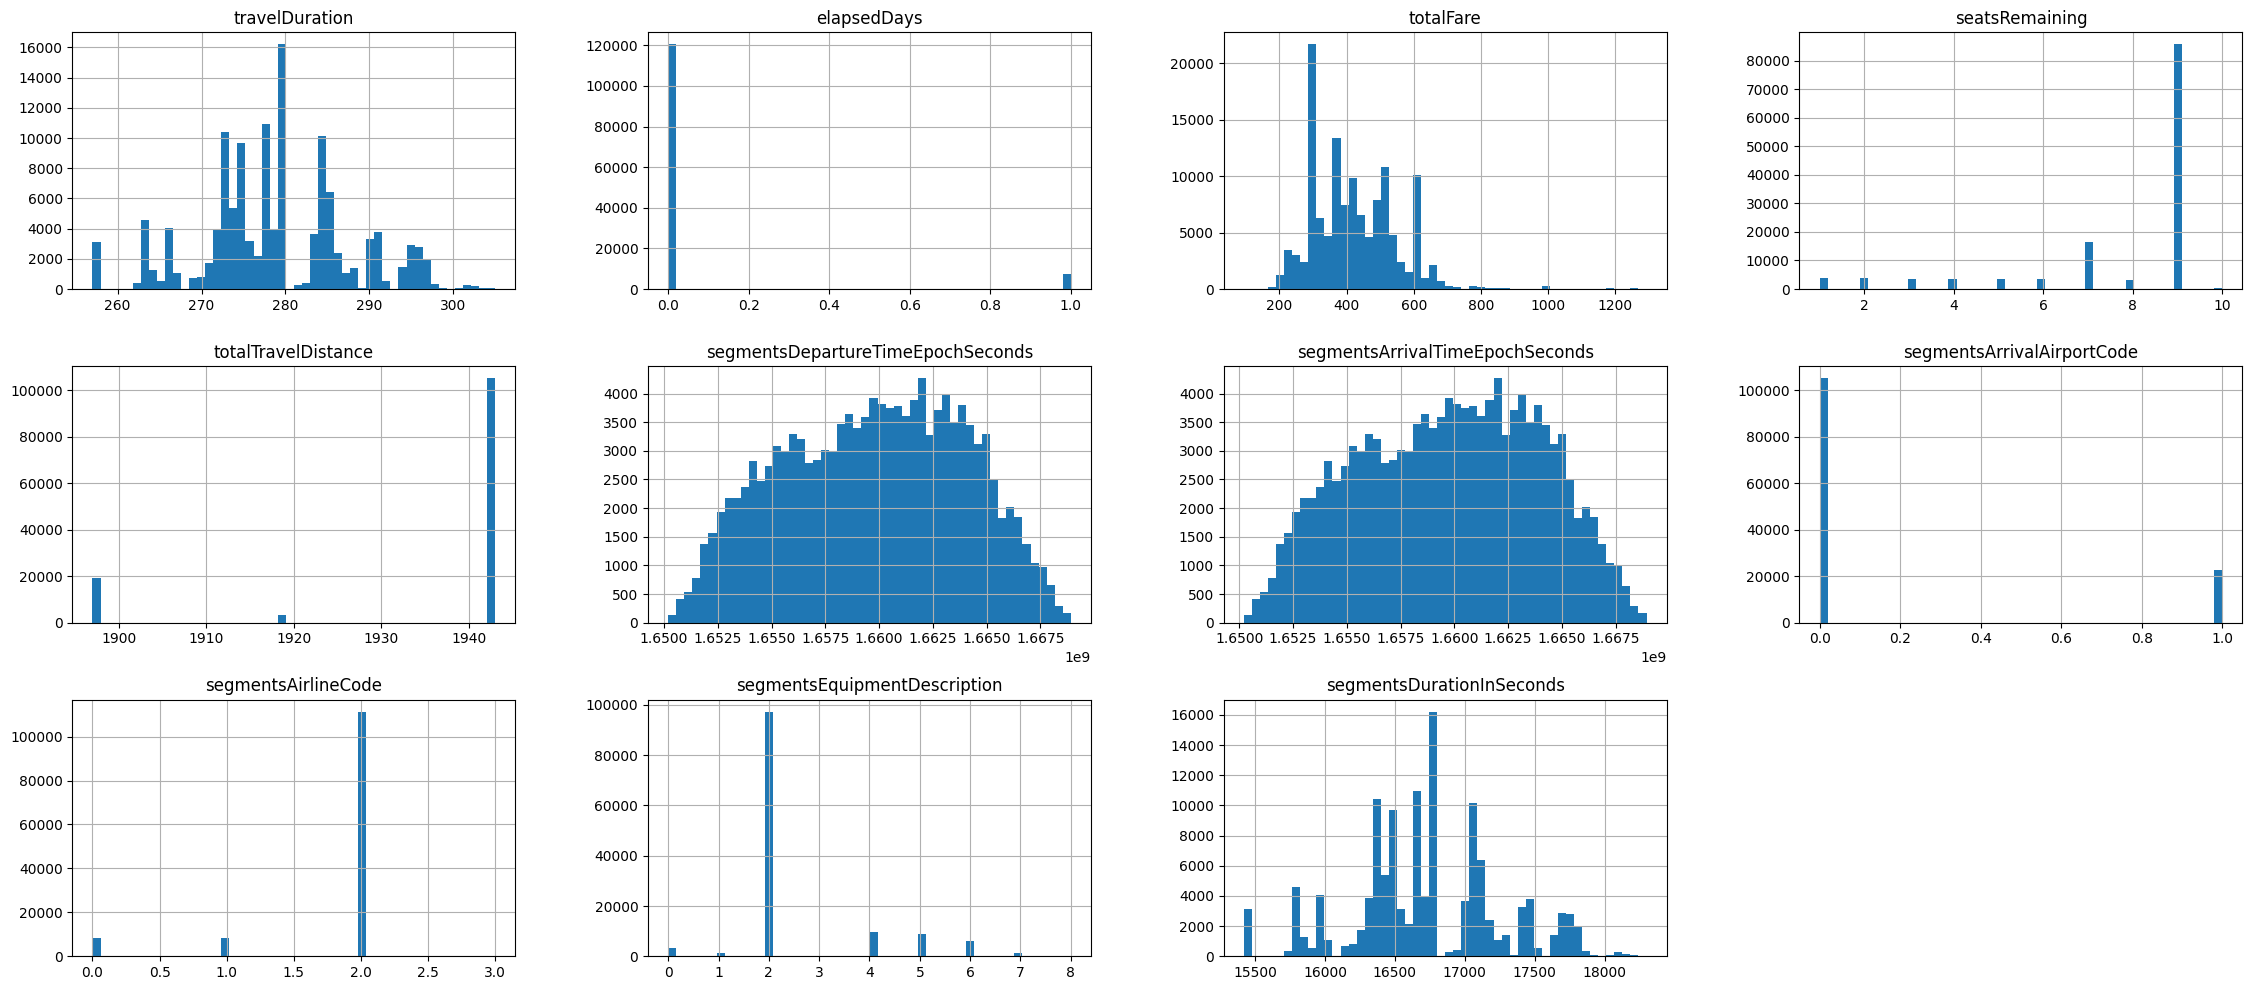

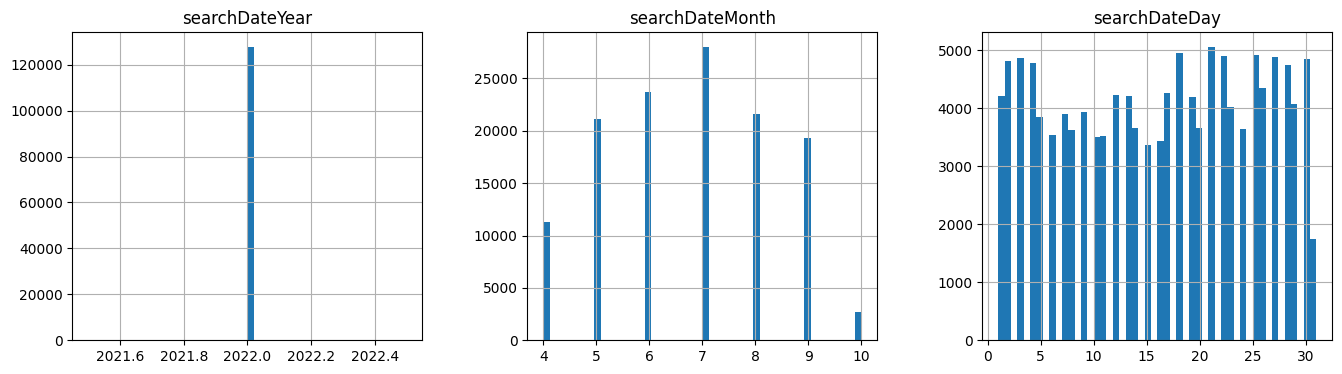

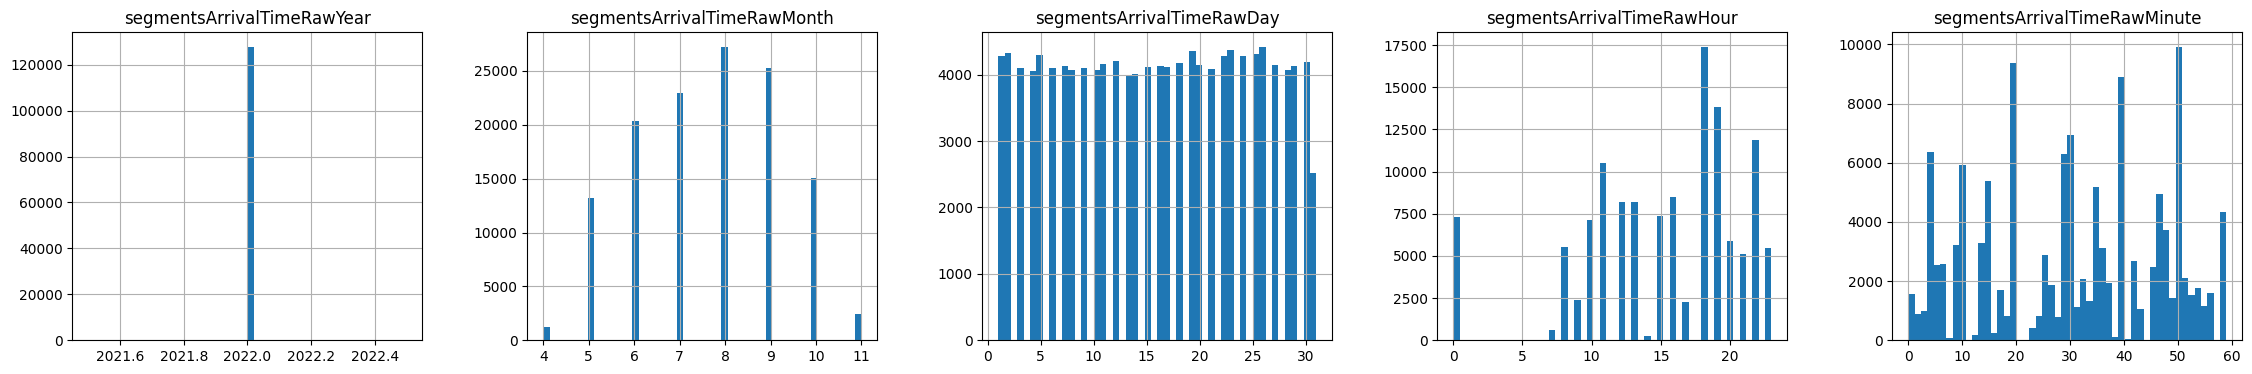

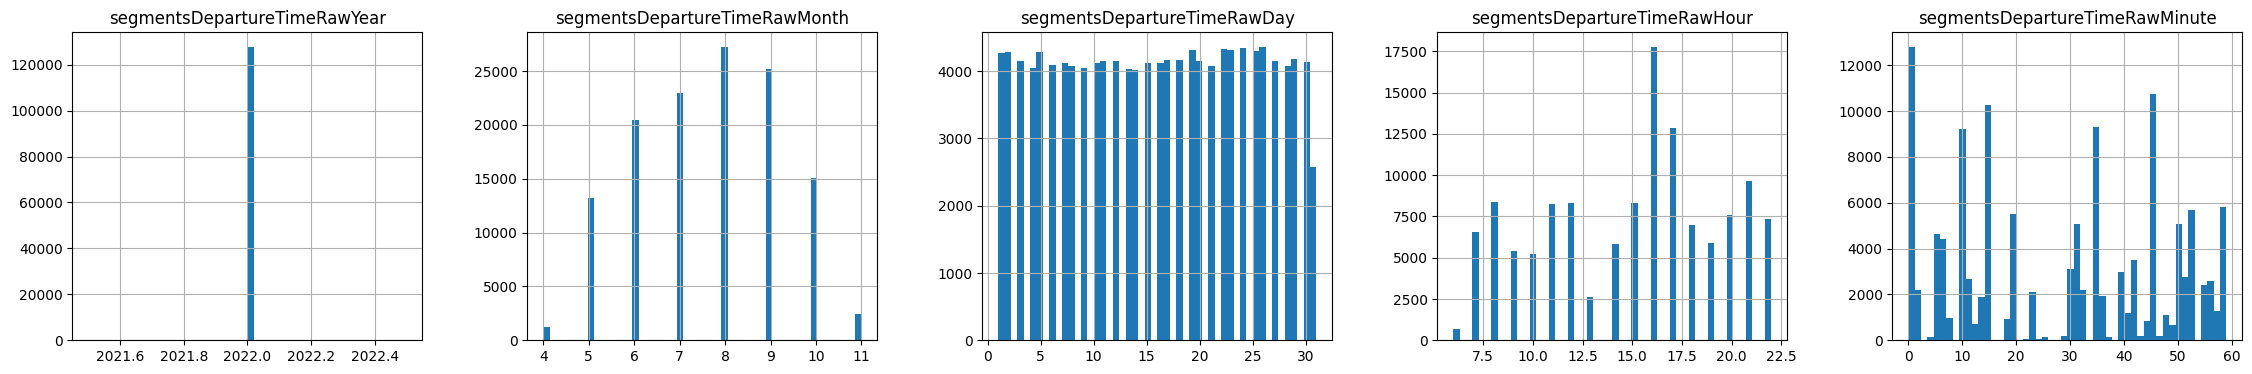

In [131]:
_df = _df.astype(np.float32)
_df.iloc[:, :11].hist(bins=50, figsize=(28, 12), layout=(3, 4))
_df.iloc[:, 11:14].hist(bins=50, figsize=(28, 4), layout=(1, 5))
_df.iloc[:, 14:19].hist(bins=50, figsize=(28, 4), layout=(1, 5))
_df.iloc[:, 19:].hist(bins=50, figsize=(28, 4), layout=(1, 5));

看來 travelDuration 幾乎與 segmentsDurationInSeconds 相等

但是與 totalFare 的關係不是很明顯

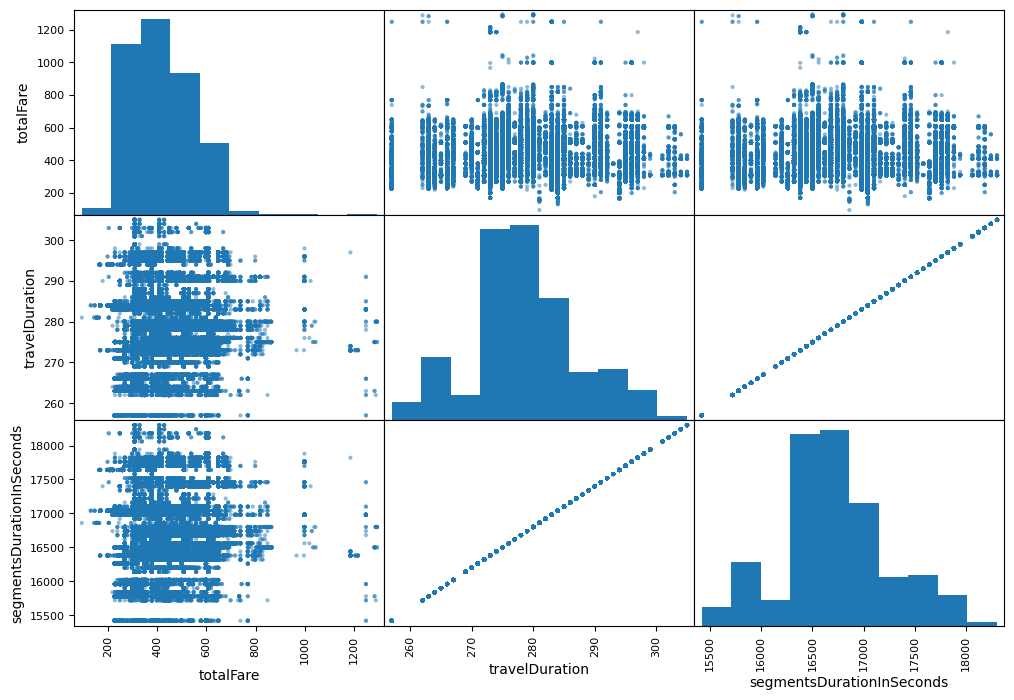

In [132]:
from pandas.plotting import scatter_matrix
# _df[["fareBasisCode", "isBasicEconomy"]].plot.scatter(x="fareBasisCode", y="isBasicEconomy", alpha=0.1)
scatter_matrix(_df[["totalFare", "travelDuration", "segmentsDurationInSeconds"]], figsize=(12, 8));

totalTravelDistance 與 segmentsArrivalAirportCode 高度相關，並非線性關係，而是多對一的關係 (3 -> 2)，兩者當中將選用種類較少的 segmentsArrivalAirportCode 當作代表。

關於為甚麼都是抵達 LAX 的機票會有不同的 ArrivalAirportCode，是因為 LAX 會和鄰近的機場 ONT 借用大型的跑道。但是資訊上都是寫到 LAX (也許航空公司會負往 LAX 的交通吧)

但是與 totalFare 的關聯也不明顯。

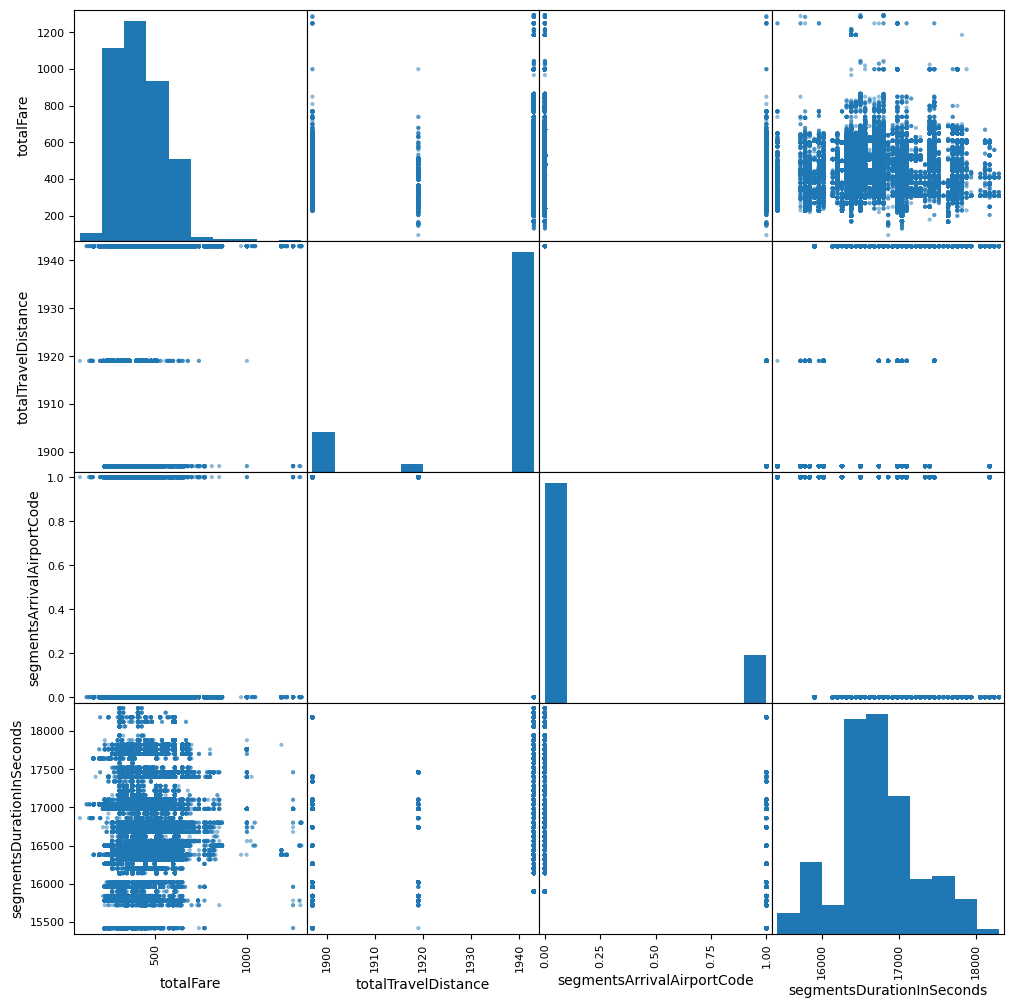

In [99]:
scatter_matrix(
    _df[[
        "totalFare",
        "totalTravelDistance",
        "segmentsArrivalAirportCode",
        "segmentsDurationInSeconds",
    ]],
    figsize=(12, 12)
);

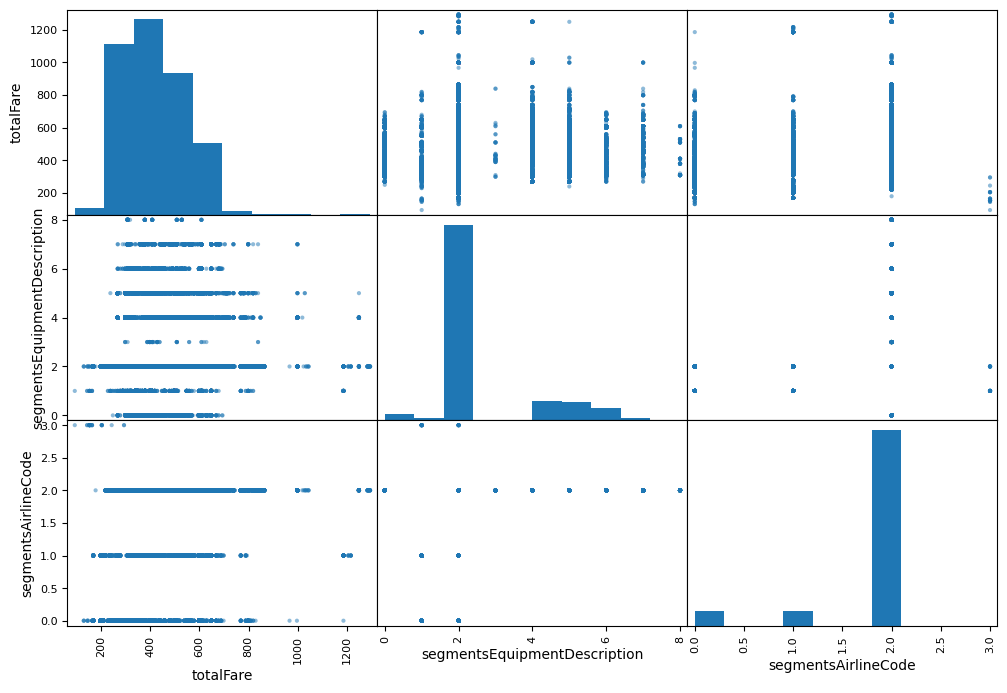

In [100]:
scatter_matrix(
    _df[[
        "totalFare",
        "segmentsEquipmentDescription",
        "segmentsAirlineCode",
    ]],
    figsize=(12, 8)
);

留下 DepartureTime

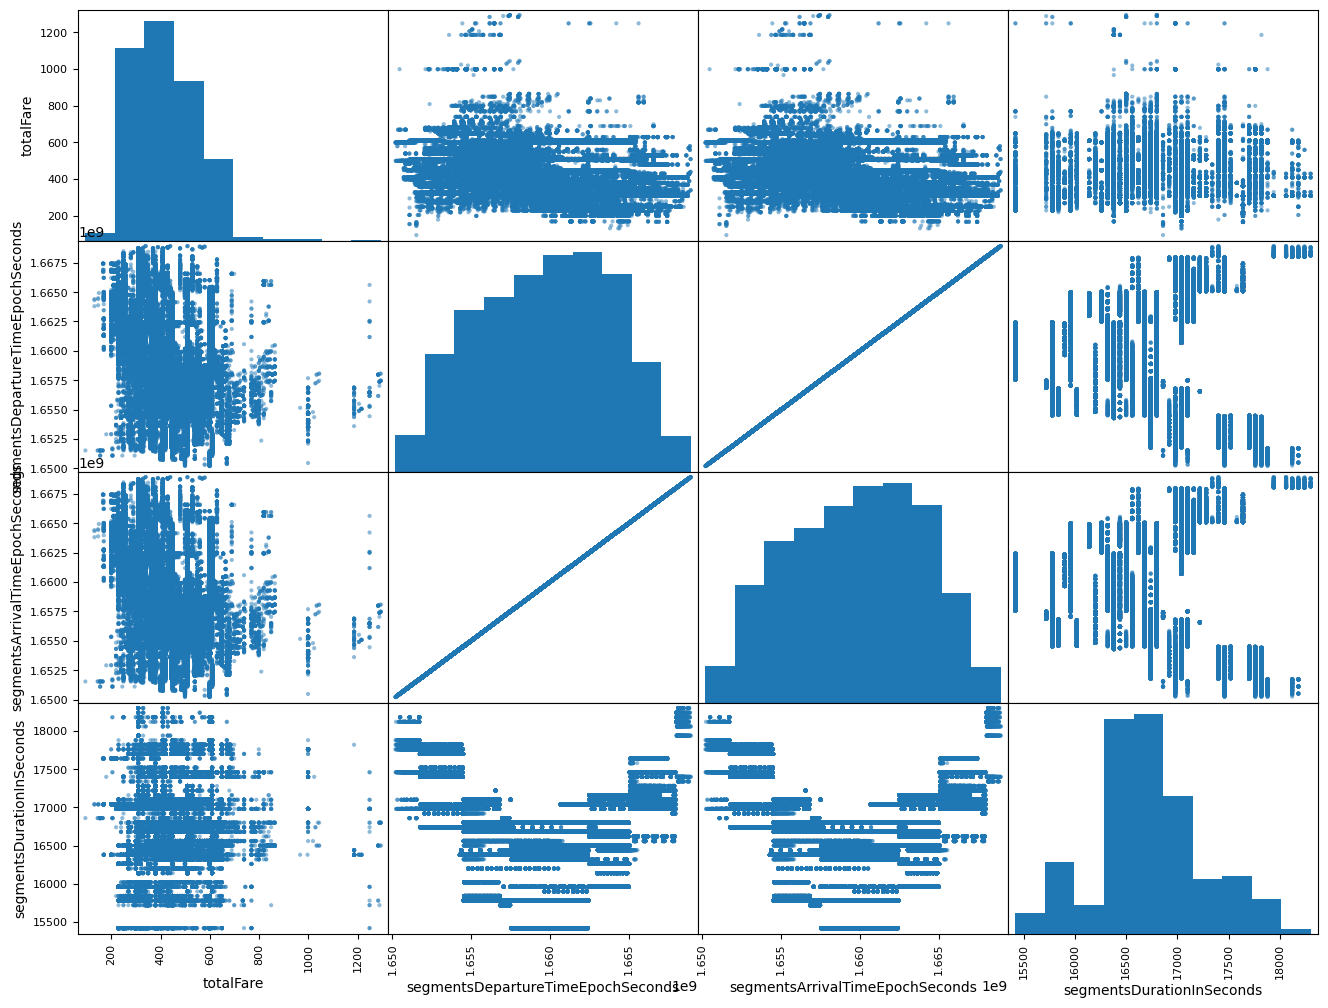

In [122]:
scatter_matrix(
    _df[[
        "totalFare",
        "segmentsDepartureTimeEpochSeconds",
        "segmentsArrivalTimeEpochSeconds",
        "segmentsDurationInSeconds",
    ]],
    figsize=(16, 12)
);

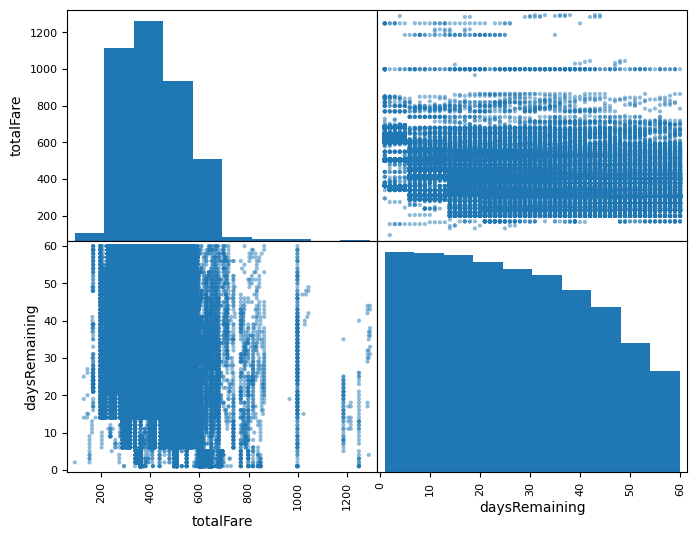

In [134]:
def calc_days_remaining(df: pd.DataFrame):
    search_timestamp = df["searchDateYear"].astype(int).astype(str)
    search_timestamp += "-" + df["searchDateMonth"].astype(int).astype(str)
    search_timestamp += "-" + df["searchDateDay"].astype(int).astype(str)
    search_timestamp = pd.to_datetime(search_timestamp)

    depart_timestamp = df["segmentsDepartureTimeRawYear"].astype(int).astype(str)
    depart_timestamp += "-" + df["segmentsDepartureTimeRawMonth"].astype(int).astype(str)
    depart_timestamp += "-" + df["segmentsDepartureTimeRawDay"].astype(int).astype(str)
    depart_timestamp = pd.to_datetime(depart_timestamp)

    df["daysRemaining"] = (depart_timestamp - search_timestamp).dt.days

calc_days_remaining(_df)

scatter_matrix(
    _df[[
        "totalFare",
        "daysRemaining",
    ]],
    figsize=(8, 6)
);

In [140]:
selected_df = filled_df.drop(
    columns=[
        "travelDuration",
        "totalTravelDistance",
        "segmentsArrivalTimeEpochSeconds",
        "segmentsArrivalTimeRawYear",
        "segmentsArrivalTimeRawMonth",
        "segmentsArrivalTimeRawDay",
        "segmentsArrivalTimeRawHour",
        "segmentsArrivalTimeRawMinute",
    ]
)
calc_days_remaining(selected_df)
selected_df[categorical_features] = ord_enc.transform(selected_df[categorical_features])
selected_df = selected_df.astype(np.float32)
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 147802 entries, ('000d78c93bdee870101b394bd2b91857', '2022-06-25') to ('fff4d4d9dd1b3b43c3e93450d3f28984', '2022-05-03')
Data columns (total 17 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   elapsedDays                        147802 non-null  float32
 1   totalFare                          147802 non-null  float32
 2   seatsRemaining                     147802 non-null  float32
 3   segmentsDepartureTimeEpochSeconds  147802 non-null  float32
 4   segmentsArrivalAirportCode         147802 non-null  float32
 5   segmentsAirlineCode                147802 non-null  float32
 6   segmentsEquipmentDescription       147802 non-null  float32
 7   segmentsDurationInSeconds          147802 non-null  float32
 8   searchDateYear                     147802 non-null  float32
 9   searchDateMonth                    147802 non-null  float32
 10  searchDateD

In [141]:
selected_df

elapsedDays   totalFare  \
legId                            searchDate                            
000d78c93bdee870101b394bd2b91857 2022-06-25          0.0  238.600006   
                                 2022-06-26          0.0  238.600006   
                                 2022-06-27          0.0  238.600006   
                                 2022-06-28          0.0  238.600006   
                                 2022-06-29          0.0  238.600006   
...                                                  ...         ...   
fff4d4d9dd1b3b43c3e93450d3f28984 2022-04-29          0.0  608.599976   
                                 2022-04-30          0.0  608.599976   
                                 2022-05-01          0.0  608.599976   
                                 2022-05-02          0.0  608.599976   
                                 2022-05-03          0.0  608.599976   

                                             seatsRemaining  \
legId                            searchDate                   
000d78c93bdee870101b394bd2b91857 2022-06-25             7.0   
                                 2022-06-26             7.0   
                                 2022-06-27             7.0   
                                 2022-06-28             7.0   
                                 2022-06-29             7.0   
...                                                     ...   
fff4d4d9dd1b3b43c3e93450d3f28984 2022-04-29             9.0   
                                 2022-04-30             9.0   
                                 2022-05-01             9.0   
                                 2022-05-02             9.0   
                                 2022-05-03             9.0   

                                             segmentsDepartureTimeEpochSeconds  \
legId                            searchDate                                      
000d78c93bdee870101b394bd2b91857 2022-06-25                       1.661200e+09   
                                 2022-06-26                       1.661200e+09   
                                 2022-06-27                       1.661200e+09   
                                 2022-06-28                       1.661200e+09   
                                 2022-06-29                       1.661200e+09   
...                                                                        ...   
fff4d4d9dd1b3b43c3e93450d3f28984 2022-04-29                       1.651669e+09   
                                 2022-04-30                       1.651669e+09   
                                 2022-05-01                       1.651669e+09   
                                 2022-05-02                       1.651669e+09   
                                 2022-05-03                       1.651669e+09   

                                             segmentsArrivalAirportCode  \
legId                            searchDate                               
000d78c93bdee870101b394bd2b91857 2022-06-25                         0.0   
                                 2022-06-26                         0.0   
                                 2022-06-27                         0.0   
                                 2022-06-28                         0.0   
                                 2022-06-29                         0.0   
...                                                                 ...   
fff4d4d9dd1b3b43c3e93450d3f28984 2022-04-29                         0.0   
                                 2022-04-30                         0.0   
                                 2022-05-01                         0.0   
                                 2022-05-02                         0.0   
                                 2022-05-03                         0.0   

                                             segmentsAirlineCode  \
legId                            searchDate                        
000d78c93bdee870101b394bd2b91857 2022-06-25                  1.0   
                                 2022-06-

totalFare                            1.000000
segmentsAirlineCode                  0.432868
segmentsDepartureTimeEpochSeconds    0.399882
segmentsDepartureTimeRawMonth        0.389680
daysRemaining                        0.387190
seatsRemaining                       0.321681
searchDateMonth                      0.277391
segmentsEquipmentDescription         0.239413
segmentsArrivalAirportCode           0.105199
segmentsDepartureTimeRawHour         0.085594
segmentsDurationInSeconds            0.075904
segmentsDepartureTimeRawMinute       0.065302
searchDateDay                        0.023566
elapsedDays                          0.016675
segmentsDepartureTimeRawDay          0.011129
searchDateYear                            NaN
segmentsDepartureTimeRawYear              NaN
Name: totalFare, dtype: float64

<BarContainer object of 17 artists>

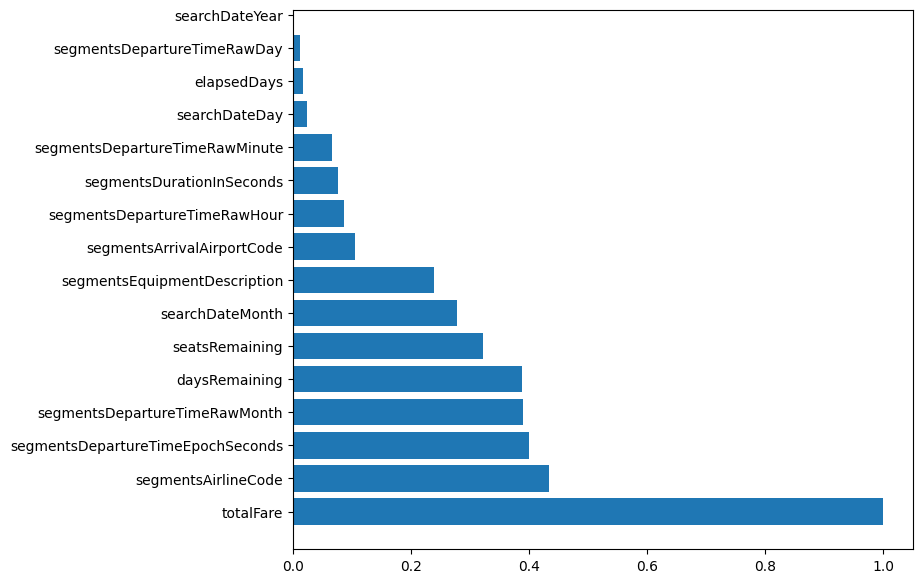

In [144]:
import matplotlib.pyplot as plt

correlation_matrix = selected_df.corr()
corr_totalFare = correlation_matrix["totalFare"].abs().sort_values(ascending=False)
display(corr_totalFare)

fig, ax = plt.subplots(figsize=(8, 7))
ax.barh(corr_totalFare.index, corr_totalFare)

### Clustering to find the possible values
Reduce redundant data before doing clustering

In [137]:
from tstide.dataframe import unique_values

display(unique_values(df_dateindex.iloc[:, :20]))
display(unique_values(df_dateindex.iloc[:, 20:40]))
df_dateindex.info()

legId                                4272
flightDate                            217
startingAirport                         1
destinationAirport                      1
fareBasisCode                         237
travelDuration                         44
elapsedDays                             2
isBasicEconomy                          2
isRefundable                            1
isNonStop                               1
baseFare                              290
totalFare                             282
seatsRemaining                         11
totalTravelDistance                     4
segmentsDepartureTimeEpochSeconds    3945
segmentsArrivalTimeEpochSeconds      3985
segmentsArrivalAirportCode              2
segmentsDepartureAirportCode            1
segmentsAirlineName                     5
segmentsAirlineCode                     5
dtype: int64

segmentsEquipmentDescription      12
segmentsDurationInSeconds         44
segmentsDistance                   4
segmentsCabinCode                  1
searchDateYear                     1
searchDateMonth                    7
searchDateDay                     31
segmentsArrivalTimeRawYear         1
segmentsArrivalTimeRawMonth        8
segmentsArrivalTimeRawDay         31
segmentsArrivalTimeRawHour        18
segmentsArrivalTimeRawMinute      57
segmentsDepartureTimeRawYear       1
segmentsDepartureTimeRawMonth      8
segmentsDepartureTimeRawDay       31
segmentsDepartureTimeRawHour      17
segmentsDepartureTimeRawMinute    53
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 147802 entries, 2022-04-16 to 2022-10-05
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              147802 non-null  object 
 1   flightDate                         147802 non-null  object 
 2   startingAirport                    147802 non-null  object 
 3   destinationAirport                 147802 non-null  object 
 4   fareBasisCode                      147802 non-null  object 
 5   travelDuration                     146651 non-null  float64
 6   elapsedDays                        147802 non-null  int64  
 7   isBasicEconomy                     147802 non-null  bool   
 8   isRefundable                       147802 non-null  bool   
 9   isNonStop                          147802 non-null  bool   
 10  baseFare                           147802 non-null  float64
 11  totalFare                      

In [25]:
constant_features = [
    "startingAirport",
    "destinationAirport",
    "isRefundable",
    "isNonStop",
    "baseFare",
    "segmentsDepartureAirportCode",
    "segmentsAirlineName", # fullname of AirlineCode. AirlineCode was choosed.
    "segmentsCabinCode",
    "flightDate", # not const but redundant
    "segmentsDistance" # duplicated to totalTravelDistance
]

ancestor_df = filled_df.reset_index().drop(columns=constant_features)

categorical_features = [
    'fareBasisCode',
    'isBasicEconomy',
    "segmentsArrivalAirportCode",
    'segmentsAirlineCode',
    'segmentsEquipmentDescription'
]

In [26]:
from collections import namedtuple
NaIndex = namedtuple("NaIndex", ["na", "non_na"])
na_index_travelDuration = NaIndex(
    ancestor_df.index[ancestor_df["travelDuration"].isna()],
    ancestor_df.index[~ancestor_df["travelDuration"].isna()]
)
na_index_TravelDistance = NaIndex(
    ancestor_df.index[ancestor_df["totalTravelDistance"].isna()],
    ancestor_df.index[~ancestor_df["totalTravelDistance"].isna()],
)
na_index_EquipmentDescription = NaIndex(
    ancestor_df.index[ancestor_df["segmentsEquipmentDescription"].isna()],
    ancestor_df.index[~ancestor_df["segmentsEquipmentDescription"].isna()],
)

print("travelDuration & TravelDistance: ")
display(na_index_travelDuration.na.intersection(na_index_TravelDistance.na))
print("travelDuration & EquipmentDescription: ")
display(na_index_travelDuration.na.intersection(na_index_EquipmentDescription.na))
print("TravelDistane & EquipmentDescription: ")
display(na_index_TravelDistance.na.intersection(na_index_EquipmentDescription.na))

travelDuration & TravelDistance: 


Int64Index([], dtype='int64')

travelDuration & EquipmentDescription: 


Int64Index([], dtype='int64')

TravelDistane & EquipmentDescription: 


Int64Index([  3701,   3702,   3703,   3704,   3705,   3706,   3707,   3708,
              3709,   3710,
            ...
            147445, 147446, 147447, 147448, 147449, 147450, 147451, 147452,
            147453, 147454],
           dtype='int64', length=4589)

### totalTravelDistance & segmentsEquipmentDescription
Consider them together, for their intersection is large.

Text(0, 0.5, 'count')

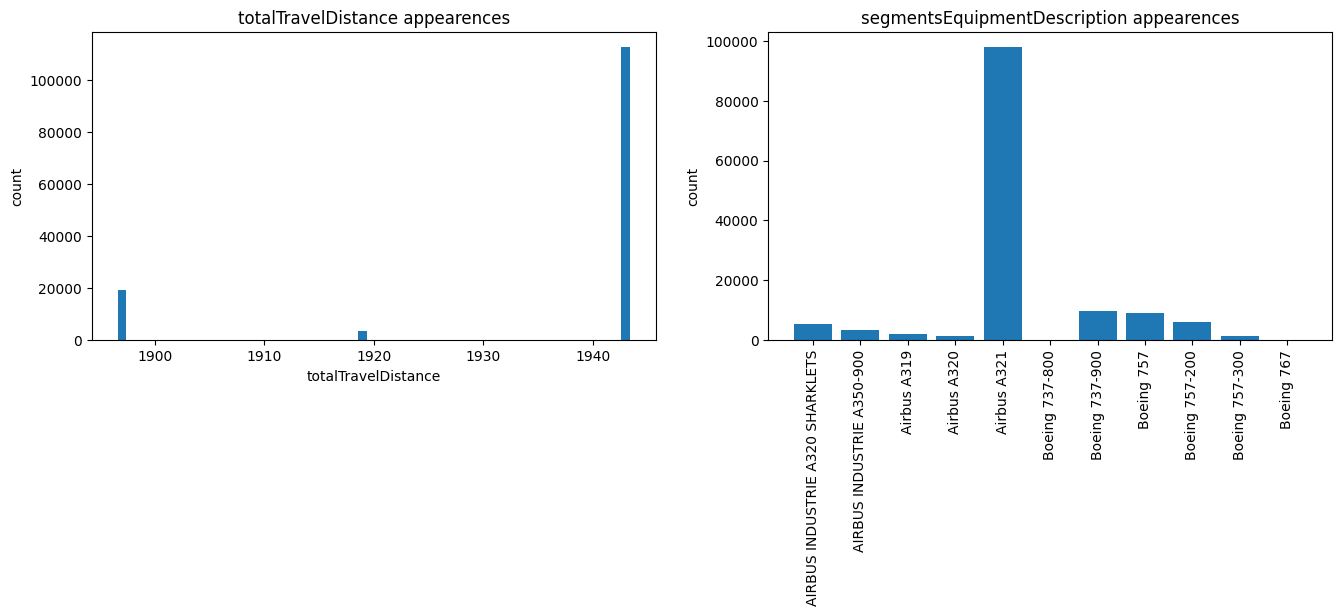

In [58]:
import matplotlib.pyplot as plt

_value_count = ancestor_df["totalTravelDistance"].value_counts().sort_index()
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
axes[0].set_title("totalTravelDistance appearences")
axes[0].bar(_value_count.index, _value_count)
axes[0].set_xlabel("totalTravelDistance")
axes[0].set_ylabel("count")

_value_count = ancestor_df["segmentsEquipmentDescription"].value_counts().sort_index()
axes[1].tick_params(axis="x", labelrotation=90)
axes[1].set_title("segmentsEquipmentDescription appearences")
axes[1].bar(_value_count.index, _value_count)
axes[1].set_ylabel("count")

In [69]:
_to_impute = ancestor_df.copy().loc[na_index_TravelDistance.non_na.intersection(na_index_EquipmentDescription.non_na)]
_to_impute.dropna(inplace=True)
_TravelDistance = _to_impute.pop("totalTravelDistance")
_EquipmentDescription = _to_impute.pop("segmentsEquipmentDescription")


#### travelDuration
大概分成 5 群，clustering 先用 n=5

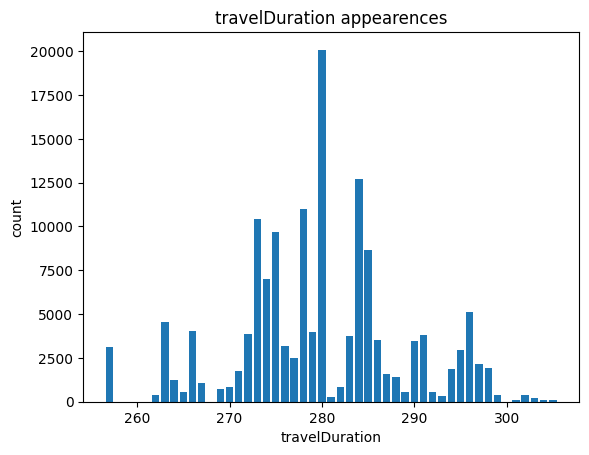

In [41]:
import matplotlib.pyplot as plt

_value_count = ancestor_df["travelDuration"].value_counts().sort_index()
fig, ax = plt.subplots()
ax.set_title("travelDuration appearences")
ax.bar(_value_count.index, _value_count)
ax.set_xlabel("travelDuration")
ax.set_ylabel("count");

In [171]:
_na_index = ancestor_df[ancestor_df["travelDuration"].isna()].index
_non_na_index = ancestor_df[~(ancestor_df["travelDuration"].isna())].index

In [190]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

_df = ancestor_df.loc[_non_na_index].copy()
_df = _df.drop(columns=["legId", "searchDate"])
_df = _df.dropna()
ord_enc = OrdinalEncoder()
_df[categorical_features] = ord_enc.fit_transform(_df[categorical_features])
travel_duration_scaler = StandardScaler()
_X = travel_duration_scaler.fit_transform(_df.to_numpy(np.float32))

In [197]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

_scores = []
for i in range(2, 8):
    travel_duration_kmeans = KMeans(n_clusters=i, init="k-means++", n_init="auto")
    travel_duration_kmeans.fit(_X)
    _scores.append(silhouette_score(_X, travel_duration_kmeans.labels_))

In [202]:
_scores

[0.15222324, 0.18453187, 0.1334183, 0.12953982, 0.14178763, 0.16181934]

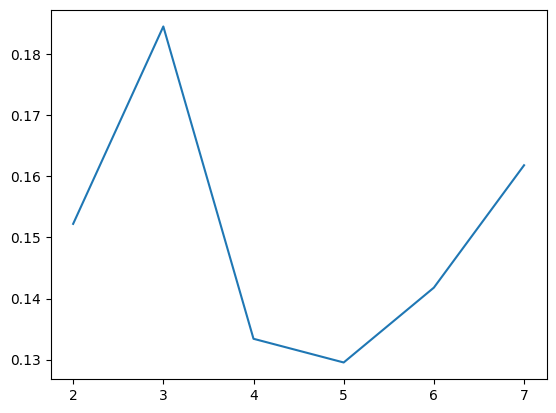

In [199]:
plt.figure()
plt.plot(range(2, 8), _scores)
plt.show()

In [205]:
travel_duration_kmeans = KMeans(n_clusters=3, init="k-means++", n_init="auto")
travel_duration_kmeans.fit(_X)

KMeans(n_clusters=3, n_init='auto')

## Feature Selection
Filter the constant features

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

travel_duration_ord_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=0)

In [85]:
dataset["segmentsDistance"] = dataset["segmentsDistance"].astype(int)
dataset.info()

ValueError: cannot convert float NaN to integer

In [72]:
from sklearn.preprocessing import OrdinalEncoder

prep_ord_enc = OrdinalEncoder()
categorical_features = [
    'fareBasisCode',
    'isBasicEconomy',
    "segmentsArrivalAirportCode",
    'segmentsAirlineCode',
    'segmentsEquipmentDescription'
]
dataset[categorical_features] = prep_ord_enc.fit_transform(
    dataset[categorical_features]
)
dataset

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']

In [77]:
dataset_arr = dataset.iloc[:, 2:].to_numpy(np.float32)
dataset_arr

array([[ 71., 294.,   0., ...,  17.,  21.,  26.],
       [ 71., 295.,   0., ...,  17.,   6.,  35.],
       [ 32., 283.,   0., ...,  17.,  18.,  22.],
       ...,
       [ 69., 304.,   0., ...,  12.,   9.,  43.],
       [145.,  nan,   0., ...,  12.,  13.,  34.],
       [145.,  nan,   0., ...,  12.,   8.,  10.]], dtype=float32)